In [146]:
import pandas as pd
import numpy as np
import holidays
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder

plt.style.use('seaborn-v0_8')

In [147]:
ts_df = pd.read_csv('new_required_dataset.csv')

In [148]:
ts_df.head(50)

,Unnamed: 0,product_id,order_date,ean_code,our_price,mrp,quantity,revenue,year,month,month_year,discount
0,0,3927,2019-07-01,8901030289354,234,260,4,936,2019,7,2019-07,10
1,1,3927,2019-07-02,8901030289354,234,260,4,936,2019,7,2019-07,10
2,2,3927,2019-07-03,8901030289354,234,260,0,0,2019,7,2019-07,10
3,3,3927,2019-07-04,8901030289354,234,260,2,468,2019,7,2019-07,10
4,4,3927,2019-07-05,8901030289354,234,260,2,468,2019,7,2019-07,10
5,5,3927,2019-07-06,8901030289354,234,260,1,234,2019,7,2019-07,10
6,6,3927,2019-07-07,8901030289354,234,260,0,0,2019,7,2019-07,10
7,7,3927,2019-07-08,8901030289354,234,260,2,468,2019,7,2019-07,10
8,8,3927,2019-07-09,8901030289354,234,260,3,702,2019,7,2019-07,10
9,9,3927,2019-07-10,8901030289354,260,260,4,1040,2019,7,2019-07,0


In [149]:
shifted_rolling = ts_df['quantity'].shift(1).rolling(window=5).mean()
ceiling_rolling = np.ceil(shifted_rolling)

ts_df['quantity'] = np.where(ts_df['quantity'] == 0, 0, ceiling_rolling)
ts_df['quantity'] = ts_df['quantity'].bfill().ffill()
ts_df['quantity'] = ts_df['quantity'].astype(int)


In [150]:
def create_daily_features(df):
    df = df.copy()
    df['lag_1'] = df['quantity'].shift(1)
    df['lag_2'] = df['quantity'].shift(2)
    df['lag_7'] = df['quantity'].shift(7)
    df['roll_mean_3'] = df['quantity'].shift(1).rolling(window=3).mean()
    df['roll_mean_7'] = df['quantity'].shift(1).rolling(window=7).mean()
    df['roll_mean_14'] = df['quantity'].shift(1).rolling(window=14).mean()
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    df.fillna(0, inplace=True)
    return df

In [151]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

In [152]:
ts_df['order_date'] = pd.to_datetime(ts_df['order_date'])
top_products = ts_df.groupby('ean_code')['quantity'].sum().nlargest(10).index.tolist()
train_end = '2022-04-30'
ts_df = ts_df[ts_df['ean_code'].isin(top_products)].copy()
all_results = []

In [153]:
agg_df = ts_df.groupby(['ean_code', 'order_date']).agg({'quantity': 'sum', 'discount': 'median'}).sort_index()
agg_df = agg_df.reset_index()

le = LabelEncoder()
agg_df['ean_code_encoded'] = le.fit_transform(agg_df['ean_code'])

agg_df.set_index('order_date', inplace=True)
agg_df = create_daily_features(agg_df)

features = ['lag_1', 'lag_2', 'lag_7', 'roll_mean_3', 'roll_mean_7', 'roll_mean_14',
            'dayofweek', 'dayofmonth', 'weekofyear', 'month', 'quarter',
            'is_month_start', 'is_month_end', 'is_weekend', 'ean_code_encoded']

In [154]:
train_end = pd.to_datetime(train_end)

train_data = agg_df.loc[agg_df.index <= train_end]
test_data = agg_df.loc[agg_df.index > train_end]

train_data = train_data.dropna(subset=features + ['quantity'])
test_data = test_data.dropna(subset=features + ['quantity'])

X_train = train_data[features]
y_train = train_data['quantity']
X_test = test_data[features]
y_test = test_data['quantity']

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_estimators=500,
    max_depth=7,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1
)
xgb_model.fit(X_train, y_train)

model_filename = f"xgb_model_train_newwwwwwwwww.json"
xgb_model.save_model(model_filename)
print(f"Model saved to {model_filename}")

y_pred = xgb_model.predict(X_test)
mae, rmse, r2 = evaluate(y_test, y_pred)
print(f"Train until {train_end.date()} | Test size: {len(y_test)} | MAE: {mae:.3f}, RMSE: {rmse:.3f}, R2: {r2:.3f}")

all_results.append({
    'Train_End_Date': train_end.date(),
    'Test_Size': len(y_test),
    'MAE': mae,
    'RMSE': rmse,
    'R2': r2
})

results_df = pd.DataFrame(all_results)
print("\nSummary of all runs:")
print(results_df)

Model saved to xgb_model_train_newwwwwwwwww.json
Train until 2022-04-30 | Test size: 1530 | MAE: 34.220, RMSE: 72.190, R2: 0.916

Summary of all runs:
  Train_End_Date  Test_Size        MAE      RMSE        R2
0     2022-04-30       1530  34.220139  72.19006  0.915798


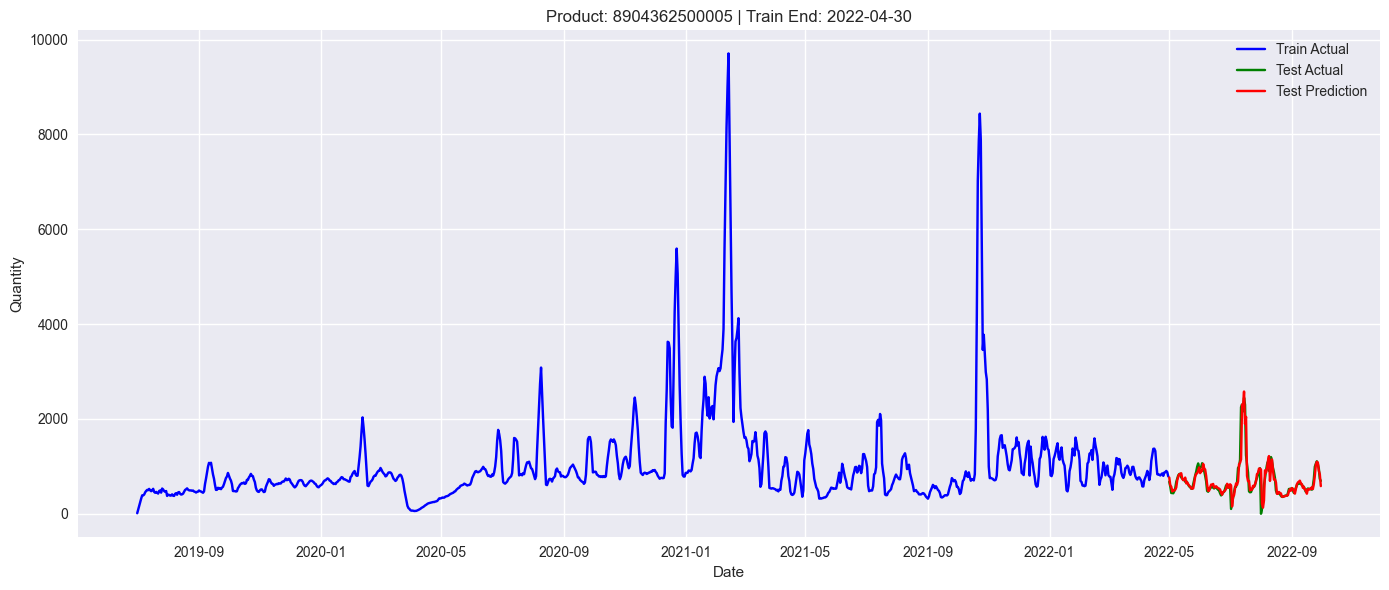

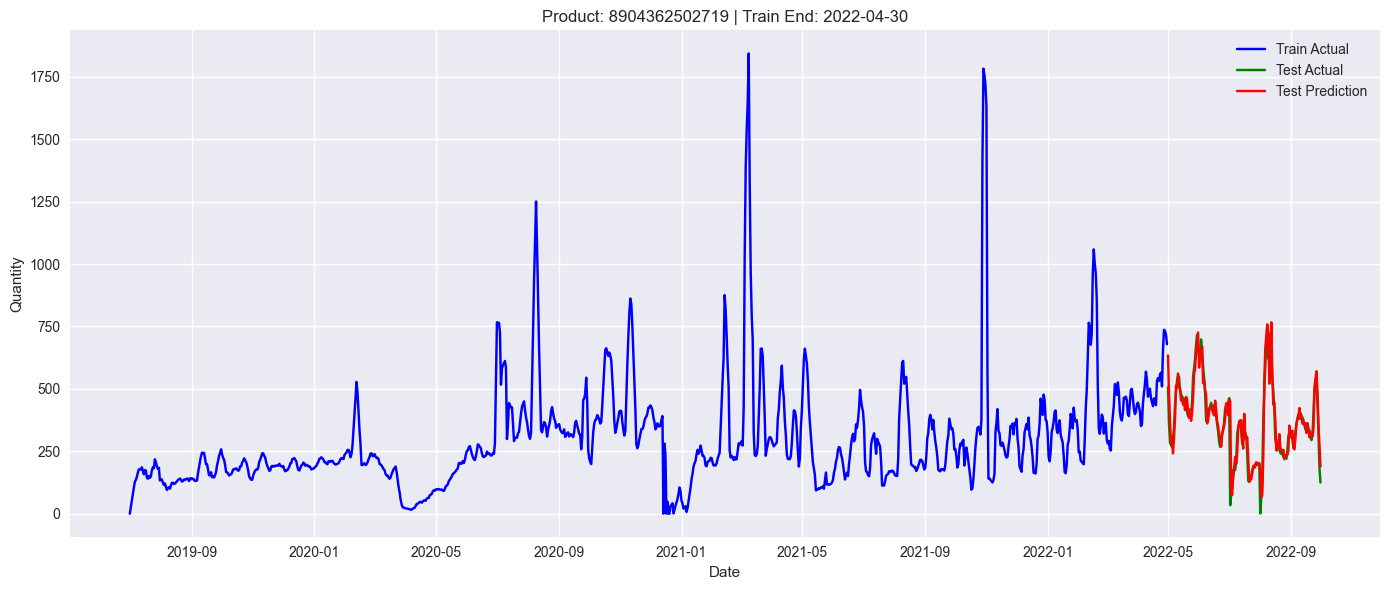

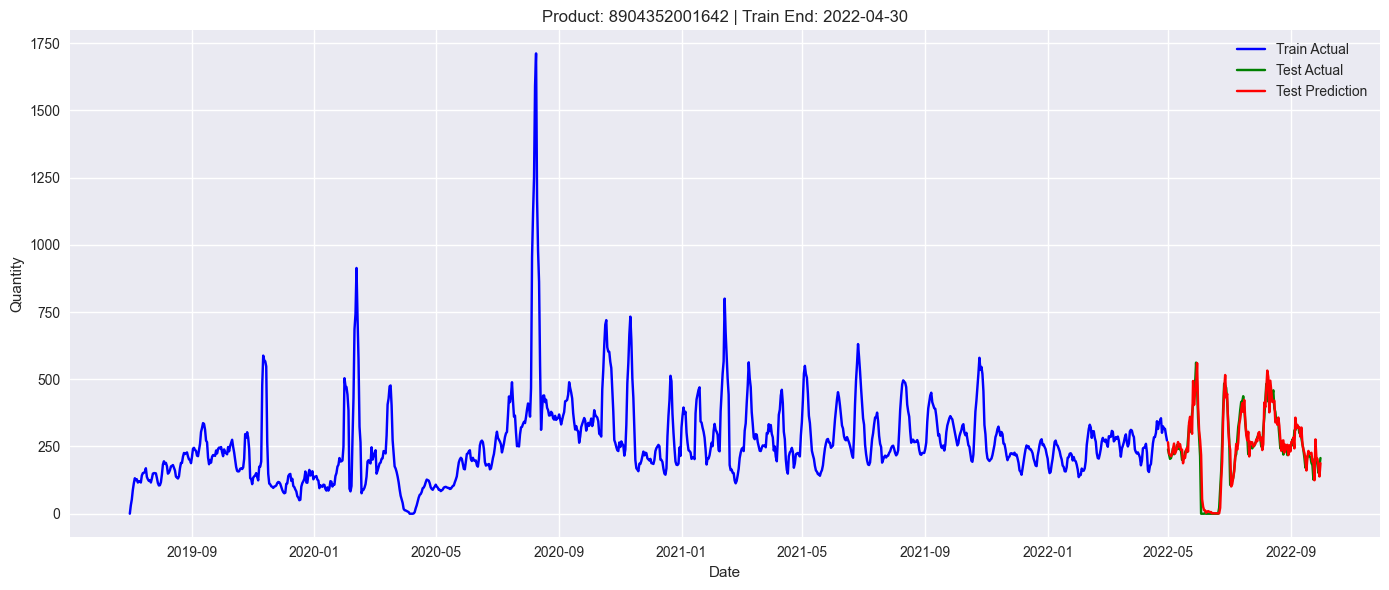

In [155]:
test_data['predicted_quantity'] = y_pred

products_to_plot = top_products[:3]

for prod in products_to_plot:
    plt.figure(figsize=(14, 6))
    train_prod = train_data[train_data['ean_code'] == prod]
    test_prod = test_data[test_data['ean_code'] == prod]
    
    plt.plot(train_prod.index, train_prod['quantity'], label='Train Actual', color='blue')
    plt.plot(test_prod.index, test_prod['quantity'], label='Test Actual', color='green')    
    plt.plot(test_prod.index, test_prod['predicted_quantity'], label='Test Prediction', color='red')
    
    plt.title(f'Product: {prod} | Train End: {train_end.date()}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [156]:
agg_df.head()

,ean_code,quantity,discount,ean_code_encoded,lag_1,lag_2,lag_7,roll_mean_3,roll_mean_7,roll_mean_14,dayofweek,dayofmonth,weekofyear,month,quarter,is_month_start,is_month_end,is_weekend
order_date,,,,,,,,,,,,,,,,,,
2019-07-01,6902395722403,0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.0,0,1,27,7,3,1,0,0
2019-07-02,6902395722403,0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,27,7,3,0,0,0
2019-07-03,6902395722403,0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.0,2,3,27,7,3,0,0,0
2019-07-04,6902395722403,0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.0,3,4,27,7,3,0,0,0
2019-07-05,6902395722403,0,12.5,0,0.0,0.0,0.0,0.0,0.0,0.0,4,5,27,7,3,0,0,0


In [163]:
model_path = "xgb_model_train_newwwwwwwwww.json"
xgb_model = xgb.XGBRegressor()
xgb_model.load_model(model_path)

forecast_start_date = pd.to_datetime('2022-10-01')
forecast_end_date = forecast_start_date + pd.Timedelta(days=822 - 1)

forecast_rows = []
products = agg_df['ean_code'].unique()

for product in top_products:
    df_prod = agg_df[agg_df['ean_code'] == product].copy()
    df_prod = df_prod.sort_index()
    
    history = df_prod.loc[:'2022-09-30'].copy()
    
    current_date = forecast_start_date
    
    while current_date <= forecast_end_date:
        new_row = pd.DataFrame({
            'ean_code': [product],
            'discount': [history['discount'].iloc[-1]]
        }, index=[current_date])
        
        history = pd.concat([history, new_row], axis=0)

        features_df = create_daily_features(history)
        
        input_row = features_df.loc[current_date].copy()
        
        input_row['ean_code_encoded'] = le.transform([product])[0]

        X_input = input_row[features].to_frame().T
        X_input = X_input.apply(pd.to_numeric, errors='coerce').fillna(0)

        y_pred = xgb_model.predict(X_input)[0]
        y_pred_int = int(round(y_pred))
        if y_pred_int < 0:
            y_pred_int = 0
       
        forecast_rows.append({
            'ean_code': product,
            'order_date': current_date,
            'predicted_quantity': y_pred_int
        })
        
        history.loc[current_date, 'quantity'] = y_pred_int

        current_date += pd.Timedelta(days=1)

forecast_df = pd.DataFrame(forecast_rows)
forecast_df.reset_index(drop=True, inplace=True)

print(forecast_df.head())
print(f"Forecast completed for {len(products)} products from {forecast_start_date.date()} to {forecast_end_date.date()}")

        ean_code order_date  predicted_quantity
0  8904362500005 2022-10-01                 435
1  8904362500005 2022-10-02                 432
2  8904362500005 2022-10-03                 458
3  8904362500005 2022-10-04                 492
4  8904362500005 2022-10-05                 568
Forecast completed for 10 products from 2022-10-01 to 2024-12-30


In [164]:
forecast_df = forecast_df.to_csv('2year_forecasted_quantities.csv', index=False)

In [ ]:
import seaborn as sns

sns.set_style('whitegrid')

products_to_plot = top_products[:3]

plt.figure(figsize=(15, 6))

for product in products_to_plot:
    product_df = forecast_df[forecast_df['ean_code'] == product]
    plt.plot(product_df['order_date'], product_df['predicted_quantity'], label=str(product))

plt.title('Forecasted Quantity Over Time for Selected Products')
plt.xlabel('Date')
plt.ylabel('Predicted Quantity')
plt.legend(title='EAN Code')
plt.tight_layout()
plt.show()

In [ ]:
forecast_df.tail(43)

In [ ]:
imputation_df = ts_df.groupby(['ean_code', 'order_date']).agg({'quantity': 'sum'}).reset_index()

In [ ]:
imputation_df.head()

In [ ]:
def calculate_annual_growth(imputation_df, ean_codes, year_from, year_to):
    growth_rates = {}
    for ean in ean_codes:
        df_ean = imputation_df[imputation_df['ean_code'] == ean].copy()
        df_ean['year'] = df_ean['order_date'].dt.year
        
        mean_from = df_ean[df_ean['year'] == year_from]['quantity'].mean()
        mean_to = df_ean[df_ean['year'] == year_to]['quantity'].mean()
        
        if mean_from and pd.notna(mean_from) and mean_to and pd.notna(mean_to):
            growth = (mean_to / mean_from) - 1
        else:
            growth = 0
        growth_rates[ean] = growth
    return growth_rates

In [ ]:
def impute_last_3_months_2022(imputation_df, ean_codes):
    results = []
    for ean in ean_codes:
        df_ean = imputation_df[imputation_df['ean_code'] == ean].copy()
        df_ean['year'] = df_ean['order_date'].dt.year
        df_ean['month'] = df_ean['order_date'].dt.month
        
        jan_sep_2021 = df_ean[(df_ean['year'] == 2021) & (df_ean['month'] <= 9)]
        jan_sep_2022 = df_ean[(df_ean['year'] == 2022) & (df_ean['month'] <= 9)]
        
        mean_2021 = jan_sep_2021['quantity'].mean()
        mean_2022 = jan_sep_2022['quantity'].mean()
        growth_2022 = ((mean_2022 / mean_2021) - 1) if mean_2021 else 0
        
        oct_dec_2021 = df_ean[(df_ean['year'] == 2021) & (df_ean['month'].isin([10,11,12]))]
        
        for _, row in oct_dec_2021.iterrows():
            new_date = row['order_date'] + pd.DateOffset(years=1)
            imputed_qty = row['quantity'] * (1 + growth_2022)
            results.append({'ean_code': ean, 'order_date': new_date, 'quantity': imputed_qty})
    return pd.DataFrame(results)

In [ ]:
def impute_full_year(imputation_df, ean_codes, year_to_impute, prev_year_data, growth_rates):
    results = []
    forecast_dates = pd.date_range(start=f"{year_to_impute}-01-01", end=f"{year_to_impute}-12-31")
    
    for ean in ean_codes:
        growth = growth_rates.get(ean, 0)
        prev_data_ean = prev_year_data[prev_year_data['ean_code'] == ean]
        
        for d in forecast_dates:
            ref_date = d - pd.DateOffset(years=1)
            ref_row = prev_data_ean[prev_data_ean['order_date'] == ref_date]
            
            if not ref_row.empty:
                qty = ref_row.iloc[0]['quantity']
                imputed_qty = qty * (1 + growth)
            else:
                imputed_qty = 0
            results.append({'ean_code': ean, 'order_date': d, 'quantity': imputed_qty})
            
    return pd.DataFrame(results)

In [ ]:
ean_codes = top_products
oct_dec_2022_imputed = impute_last_3_months_2022(imputation_df, ean_codes)

In [ ]:
prev_year_2022 = pd.concat([
    imputation_df[(imputation_df['order_date'].dt.year == 2022) & (imputation_df['ean_code'].isin(ean_codes))],
    oct_dec_2022_imputed
], ignore_index=True)

In [ ]:
growth_2021_2022 = calculate_annual_growth(imputation_df, ean_codes, 2021, 2022)
imputed_2023 = impute_full_year(imputation_df, ean_codes, 2023, prev_year_2022, growth_2021_2022)
combined_for_growth = pd.concat([imputation_df, imputed_2023], ignore_index=True)
growth_2022_2023 = calculate_annual_growth(combined_for_growth, ean_codes, 2022, 2023)
# growth_2022_2023['6902395722403'] = 0.52
imputed_2024 = impute_full_year(imputation_df, ean_codes, 2024, imputed_2023, growth_2022_2023)

In [ ]:
for key, value in growth_2021_2022.items():
    print(key, value)

In [ ]:
for key, value in growth_2022_2023.items():
    print(key, value)

In [ ]:
print(oct_dec_2022_imputed.head())
print(imputed_2023.head())
print(imputed_2024.tail())

In [ ]:
all_actuals_df = pd.concat([oct_dec_2022_imputed, imputed_2023, imputed_2024], ignore_index=True)
forecast_df['order_date'] = pd.to_datetime(forecast_df['order_date'])
forecast_df_renamed = forecast_df.rename(columns={'predicted_quantity': 'quantity'})

In [ ]:
merged_df = pd.merge(
    all_actuals_df,
    forecast_df_renamed[['ean_code', 'order_date', 'quantity']],
    on=['ean_code', 'order_date'],
    how='inner',
    suffixes=('_actual', '_forecast')
)
merged_df['quantity_actual'] = merged_df['quantity_actual'].astype(int)
merged_df['quantity_forecast'] = merged_df['quantity_forecast'].astype(int)
merged_df = merged_df.sort_values(by=['ean_code', 'order_date']).reset_index(drop=True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

products_to_plot = top_products  # Use your top_products list

for product in products_to_plot:
    product_data = merged_df[merged_df['ean_code'] == product]
    plt.figure(figsize=(12, 5))
    
    plt.plot(product_data['order_date'], product_data['quantity_actual'], label='Actual', marker='o')
    plt.plot(product_data['order_date'], product_data['quantity_forecast'], label='Forecast', marker='x')
    
    plt.title(f'Actual vs Forecasted Quantity for EAN: {product}')
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
merged_df.head(50)

In [ ]:
def smooth_group(group):
        rolled = group['quantity_actual'].rolling(window=5, min_periods=1).mean()
        return rolled

merged_df['quantity_actual_smoothed'] = merged_df.groupby('ean_code', group_keys=False).apply(smooth_group)

In [ ]:
merged_df.head(825)

In [ ]:
mae = mean_absolute_error(merged_df['quantity_actual'], merged_df['quantity_forecast'])
mse = mean_squared_error(merged_df['quantity_actual'], merged_df['quantity_forecast'])
rmse = np.sqrt(mse)
r2 = r2_score(merged_df['quantity_actual'], merged_df['quantity_forecast'])

print(f"Accuracy of combined imputed actuals vs forecast:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²: {r2:.3f}")

In [ ]:
# Combine the earlier data (train_data) and forecasted data (forecast_df)
combined_df = pd.concat([
    agg_df.reset_index()[['ean_code', 'quantity', 'order_date']],
    forecast_df.rename(columns={'predicted_quantity': 'quantity'})[['ean_code', 'quantity', 'order_date']]
], ignore_index=True)

combined_df = combined_df[['ean_code', 'order_date', 'quantity']].sort_values(by=['ean_code', 'order_date'])
combined_df = combined_df.reset_index(drop=True)
combined_df.head(2011)


In [ ]:
combined_df.to_csv('5year_data.csv', index=False)

In [162]:
forecast_df.head()

,index,ean_code,quantity,ean_code_encoded
order_date,,,,
2022-10-01,0,8904362500005,435,4
2022-10-02,1,8904362500005,432,4
2022-10-03,2,8904362500005,458,4
2022-10-04,3,8904362500005,492,4
2022-10-05,4,8904362500005,568,4


In [166]:
forecast_df = pd.read_csv('2year_forecasted_quantities.csv', parse_dates=['order_date'])

In [168]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

forecast_df = forecast_df.rename(columns={'predicted_quantity': 'quantity'}).reset_index()
forecast_df['order_date'] = pd.to_datetime(forecast_df['order_date'])
forecast_df.set_index('order_date', inplace=True)
le = LabelEncoder()
forecast_df['ean_code_encoded'] = le.fit_transform(forecast_df['ean_code'])

dfs = []
for product_code, group in forecast_df.groupby('ean_code'):
    group = create_daily_features(group)
    group['ean_code'] = product_code
    dfs.append(group)



features = ['lag_1', 'lag_2', 'lag_7', 'roll_mean_3', 'roll_mean_7', 'roll_mean_14',
            'dayofweek', 'dayofmonth', 'weekofyear', 'month', 'quarter',
            'is_month_start', 'is_month_end', 'is_weekend', 'ean_code_encoded']

forecast_features_df = pd.concat(dfs).reset_index()

X = forecast_features_df[features]
y = forecast_features_df['quantity']

model_path = "xgb_model_train_until_2022-04-30.json"
xgb_model = xgb.XGBRegressor()
xgb_model.load_model(model_path)

# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     random_state=42,
#     n_estimators=500,
#     max_depth=7,
#     learning_rate=0.05,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     min_child_weight=3,
#     gamma=0,
#     reg_alpha=0,
#     reg_lambda=1
# )

xgb_model.fit(X, y)
y_pred = xgb_model.predict(X)

# Evaluate performance
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
r2 = r2_score(y, y_pred)

print(f"Continued Training on 2-year Forecast Data Results:")
print(f"MAE: {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R2: {r2:.3f}")

# Optionally save the updated model
# trained_booster.save_model('xgb_finetuned_model.json')


Continued Training on 2-year Forecast Data Results:
MAE: 4.032
RMSE: 5.891
R2: 1.000


In [169]:
model_filename = f"Purplle XGB Trained Model_5yrs.json"
xgb_model.save_model(model_filename)
print(f"Model saved to {model_filename}")

Model saved to Purplle XGB Trained Model_5yrs.json
